In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence
from skopt import gp_minimize

In [2]:
# Importing the composition and properties database
db = pd.read_excel('FeNiCo_comp-prop.xlsx')
db = db.iloc[:,1:]
db.head()

,Fe,Co,Ni,V,Mo,Cr,Cu,Mn,C,W,...,Si,Ms,Hc,Tc,ER,TS,YS,Elong,HV,Cost
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.23,NaN,724.0,8.56,NaN,NaN,NaN,NaN,0.42
1,99.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.24,NaN,739.0,11.90,NaN,NaN,NaN,NaN,0.77
2,98.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.25,NaN,753.0,14.13,NaN,NaN,NaN,NaN,1.11
3,97.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.26,NaN,767.0,15.94,NaN,NaN,NaN,NaN,1.45
4,96.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.27,NaN,780.0,17.64,NaN,NaN,NaN,NaN,1.79


In [3]:
# information about the database
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Ms      907 non-null    float64
 16  Hc      602 non-null    float64
 17  Tc      874 non-null    float64
 18  ER      421 non-null    float64
 19  TS      244 non-null    float64
 20  YS      239 non-null    float64
 21  Elong   246 non-null    float64
 22  

In [4]:
# Extracting composition and elongation to a new dataframe
df = pd.concat([db.iloc[:,:15],db.iloc[:,21]],axis=1)
df.head()

,Fe,Co,Ni,V,Mo,Cr,Cu,Mn,C,W,Ta,Nb,Al,Ti,Si,Elong
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,99.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,98.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,97.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,96.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [5]:
# information about the database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Elong   246 non-null    float64
dtypes: float64(16)
memory usage: 151.1 KB


In [6]:
# Droping all the rows with empty Ms and storing into a new dataframe
full_df = df.dropna()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 202 to 1166
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      246 non-null    float64
 1   Co      246 non-null    float64
 2   Ni      246 non-null    float64
 3   V       246 non-null    float64
 4   Mo      246 non-null    float64
 5   Cr      246 non-null    float64
 6   Cu      246 non-null    float64
 7   Mn      246 non-null    float64
 8   C       246 non-null    float64
 9   W       246 non-null    float64
 10  Ta      246 non-null    float64
 11  Nb      246 non-null    float64
 12  Al      246 non-null    float64
 13  Ti      246 non-null    float64
 14  Si      246 non-null    float64
 15  Elong   246 non-null    float64
dtypes: float64(16)
memory usage: 32.7 KB


In [7]:
# Defining the features dataframe
X = full_df.iloc[:,:15]
X.head()

,Fe,Co,Ni,V,Mo,Cr,Cu,Mn,C,W,Ta,Nb,Al,Ti,Si
202,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222,80.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,55.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280,22.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Defining the response dataframe
y = pd.DataFrame(np.log10(full_df.iloc[:,-1]))
y.head()

,Elong
202,1.602060
222,0.875061
247,1.845098
280,1.903090
302,1.845098


In [9]:
# Standard Scaling the features dataframe
scalerX = StandardScaler()

X_transform = pd.DataFrame(scalerX.fit_transform(X), columns = X.columns)

In [10]:
# Standard Scaling the response dataframe
scalerY = StandardScaler()

y_transform = pd.DataFrame(scalerY.fit_transform(y), columns = y.columns)

In [11]:
# Creating an array of feature names
features = X.columns.values
features

array(['Fe', 'Co', 'Ni', 'V', 'Mo', 'Cr', 'Cu', 'Mn', 'C', 'W', 'Ta',
       'Nb', 'Al', 'Ti', 'Si'], dtype=object)

In [12]:
# Creating an array of response names
response = y.columns.values
response

array(['Elong'], dtype=object)

In [13]:
# Splitting the features and response dataframes into training and testing dataframes
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform, test_size=0.2, random_state=0)

In [14]:
from sklearn import metrics

# Function to return the mean of the metric for a particular metric name
def metrics_mean(y_ac, y_pred, metric):
    scores = []
    if metric == 'rmse':
        score = round(np.sqrt(metrics.mean_squared_error(y_ac, y_pred)),3)
    elif metric == 'mae':
        score = round(metrics.mean_absolute_error(y_ac, y_pred),3)
    elif metric == 'R2':
        score = round(metrics.r2_score(y_ac, y_pred),3)
    else:
        score = np.inf
    scores.append(score)
    return np.mean(scores)

# Final function "plot" to plot the train-train predicted values, test-test predicted values and the metrics for
# each ML algorithm used
def plot(regressor_name, y_train, y_train_pred, y_test, y_test_pred):

    y_train = scalerY.inverse_transform(y_train)
    y_train_pred = scalerY.inverse_transform(y_train_pred)
    y_test = scalerY.inverse_transform(y_test)
    y_test_pred = scalerY.inverse_transform(y_test_pred)
    
    plt.figure(figsize = (14,6))
    
    # First subplot - training set
    ax1 = plt.subplot(121)
    
    # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
    y_pred_train = pd.DataFrame(y_train_pred)
    plt.scatter(y_train,y_pred_train)
    plt.plot(y_train,y_train,'k--',lw=3)
    
    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)
    
    # calculate means of the metrics
    rmse = metrics_mean(y_train,y_pred_train,'rmse')  
    mae = metrics_mean(y_train,y_pred_train,'mae')
    R2 = metrics_mean(y_train,y_pred_train,'R2')
    
    # regressor name with all metrics in the title
    plt.title(regressor_name+' training set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)
    
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
   
    # Second subplot - test set
    ax2 = plt.subplot(122)
    
    # plot "predicted values vs actual values and true predictions" graph for test set using first prediction
    y_pred_test = pd.DataFrame(y_test_pred)
    plt.scatter(y_test,y_pred_test)
    plt.plot(y_test,y_test,'k--',lw=3)
    
    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)
    
    # calculate means of the metrics
    rmse = metrics_mean(y_test,y_pred_test,'rmse')  
    mae = metrics_mean(y_test,y_pred_test,'mae')
    R2 = metrics_mean(y_test,y_pred_test,'R2')
    
    # regressor name with all metrics in the title
    plt.title(regressor_name+' test set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)
    
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
    
    plt.show()

    # return metrics for test set to record the errors across different algorithms
    return rmse, mae, R2

In [15]:
# Defining empty RMSE, MAE, and R2 dictionaries to store the metrics of each regressor
rmse_scores = {}
mae_scores = {}
R2_scores = {}

In [16]:
# Importing all the regressors used
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


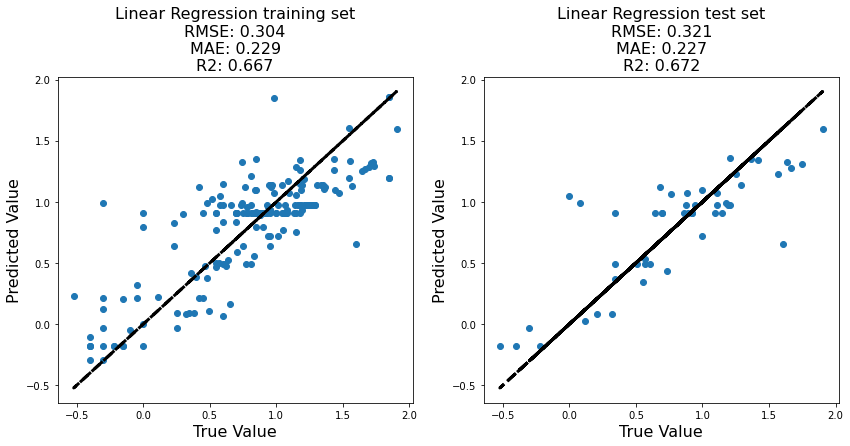

In [17]:
# create a Linear Regression regressor
lregressor = LinearRegression()

# fit and predict all the train/test arrays
lregressor.fit(X_train,y_train)
y_pred_train = lregressor.predict(X_train)
y_pred_test = lregressor.predict(X_test)

# plot the training results
rmse, mae, R2 = plot('Linear Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Linear Regression'] = rmse
mae_scores['Linear Regression'] = mae
R2_scores['Linear Regression'] = R2

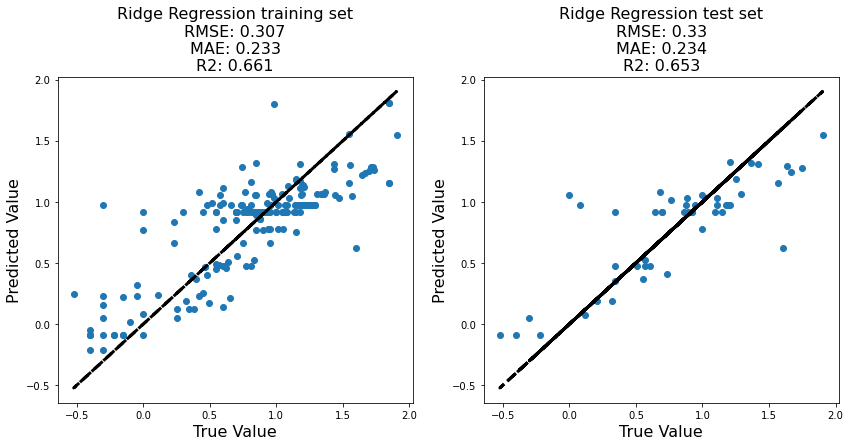

In [19]:
# RidgeCV for best alpha
from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = np.logspace(-6,6,104))
ridgecv.fit(X_train, y_train)

# Ridge Regression
rregressor = Ridge(alpha = ridgecv.alpha_)

rregressor.fit(X_train,y_train)
y_pred_train = rregressor.predict(X_train)
y_pred_test = rregressor.predict(X_test)

rmse, mae, R2 = plot('Ridge Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Ridge Regression'] = rmse
mae_scores['Ridge Regression'] = mae
R2_scores['Ridge Regression'] = R2

In [20]:
# Hyperparameter for Ridge Regression
ridgecv.alpha_

21.867836858280857

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05126684501972534, tolerance: 0.015121581027570608
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.525337687988582, tolerance: 0.015121581027570608
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5334140410862886, tolerance: 0.015121581027570608
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\shakt\anacond

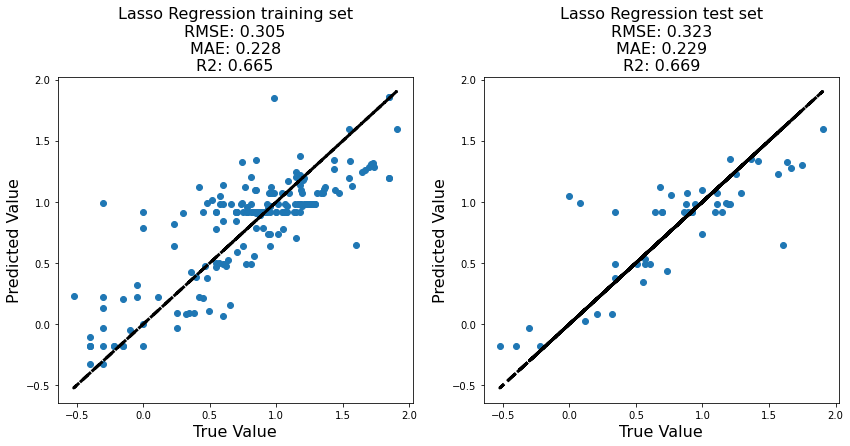

In [21]:
# LassoCV for best alpha
from sklearn.linear_model import LassoCV

y_ravel = y_train.to_numpy().ravel()

lassocv = LassoCV(alphas = np.logspace(-6,6,104))
lassocv.fit(X_train, y_ravel)

# Lasso Regression
lsregressor = Lasso(alpha = lassocv.alpha_)

lsregressor.fit(X_train,y_train)
y_pred_train = lsregressor.predict(X_train).reshape(-1,1)
y_pred_test = lsregressor.predict(X_test).reshape(-1,1)

rmse, mae, R2 = plot('Lasso Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Lasso Regression'] = rmse
mae_scores['Lasso Regression'] = mae
R2_scores['Lasso Regression'] = R2

In [22]:
# Hyperparameter for Lasso Regression
lassocv.alpha_

1e-06

In [23]:
# Function for plotting coefficients as Importance chart
def plot_coef(importance, features, title):
    
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.barh(range(len(importance)), importance, tick_label=features)
    plt.xticks(fontsize=10)
    plt.xlabel('Importance')
    plt.title(title, fontsize=16)
    plt.show()

Feature: 0, Score: 566.97225
Feature: 1, Score: 749.94782
Feature: 2, Score: 525.25250
Feature: 3, Score: 28.28474
Feature: 4, Score: 25.11030
Feature: 5, Score: 16.41808
Feature: 6, Score: 17.11037
Feature: 7, Score: 0.28867
Feature: 8, Score: 8.18785
Feature: 9, Score: 5.82322
Feature: 10, Score: 0.72732
Feature: 11, Score: 15.58715
Feature: 12, Score: 5.82622
Feature: 13, Score: 14.58608
Feature: 14, Score: 36.31334


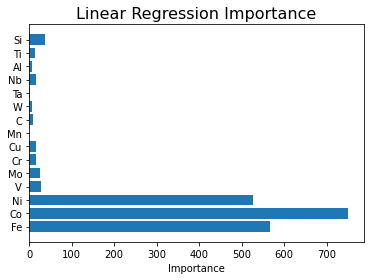

In [24]:
# Plotting Importance chart for Linear Regressor
plot_coef(lregressor.coef_.flatten(), features, 'Linear Regression Importance')

Feature: 0, Score: -0.23856
Feature: 1, Score: 0.05668
Feature: 2, Score: 0.21803
Feature: 3, Score: -0.05864
Feature: 4, Score: -0.19511
Feature: 5, Score: -0.08018
Feature: 6, Score: -0.04117
Feature: 7, Score: 0.08135
Feature: 8, Score: -0.00144
Feature: 9, Score: -0.06432
Feature: 10, Score: -0.10645
Feature: 11, Score: 0.10049
Feature: 12, Score: -0.16164
Feature: 13, Score: -0.29312
Feature: 14, Score: -0.23940


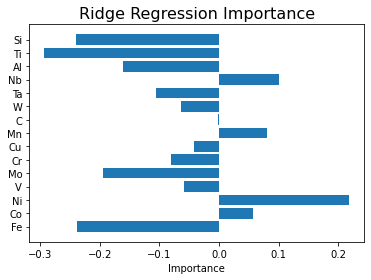

In [25]:
# Plotting Importance chart for Ridge Regressor
plot_coef(rregressor.coef_.flatten(), features, 'Ridge Regression Importance')

Feature: 0, Score: -0.35905
Feature: 1, Score: -0.10527
Feature: 2, Score: 0.11365
Feature: 3, Score: -0.09858
Feature: 4, Score: -0.18879
Feature: 5, Score: -0.11132
Feature: 6, Score: -0.04522
Feature: 7, Score: 0.09462
Feature: 8, Score: -0.01363
Feature: 9, Score: -0.07773
Feature: 10, Score: -0.11957
Feature: 11, Score: 0.12151
Feature: 12, Score: -0.19504
Feature: 13, Score: -0.35824
Feature: 14, Score: -0.28210


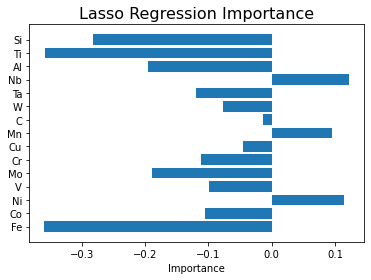

In [26]:
# Plotting Importance chart for Lasso Regressor
plot_coef(lsregressor.coef_.flatten(), features, 'Lasso Regression Importance')

In [30]:
# Hyperparameter optimization of k-Neighbors Regressor
knregressor = KNeighborsRegressor()

knr_space  = [Integer(1, 51, name='n_neighbors'),
              Categorical(categories=['auto', 'brute', 'ball_tree', 'kd_tree'], name='algorithm'),
              Integer(1, 50, name='leaf_size'),
              Integer(1, 11, name='p')]

@use_named_args(knr_space)
def objective(**params):
    knregressor.set_params(**params)
    return -np.mean(cross_val_score(knregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

knr_gp = gp_minimize(objective, knr_space, n_calls=100, n_jobs=-1, random_state=0)

C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

In [31]:
# Hyperparameter for k-Neighbors Regressor
knr_gp.x

[3, 'auto', 50, 1]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

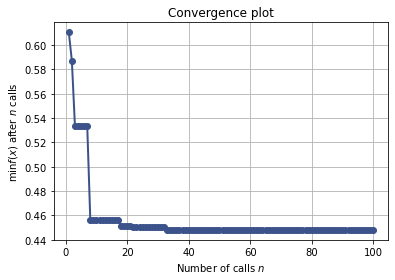

In [32]:
plot_convergence(knr_gp)

array([[<AxesSubplot:xlabel='n_neighbors', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='algorithm'>,
        <AxesSubplot:xlabel='algorithm', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='leaf_size'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='leaf_size', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_neighbors', ylabel='p'>,
        <AxesSubplot:xlabel='algorithm'>,
        <AxesSubplot:xlabel='leaf_size'>,
        <AxesSubplot:xlabel='p', ylabel='Partial dependence'>]],
      dtype=object)

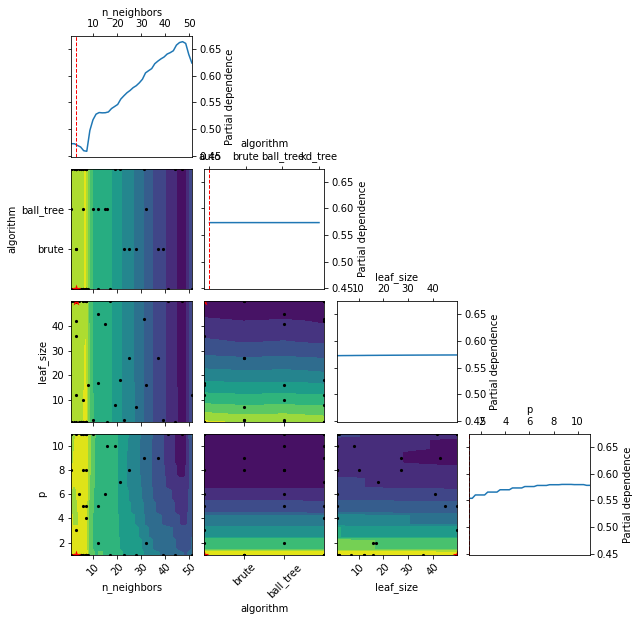

In [33]:
plot_objective(knr_gp)

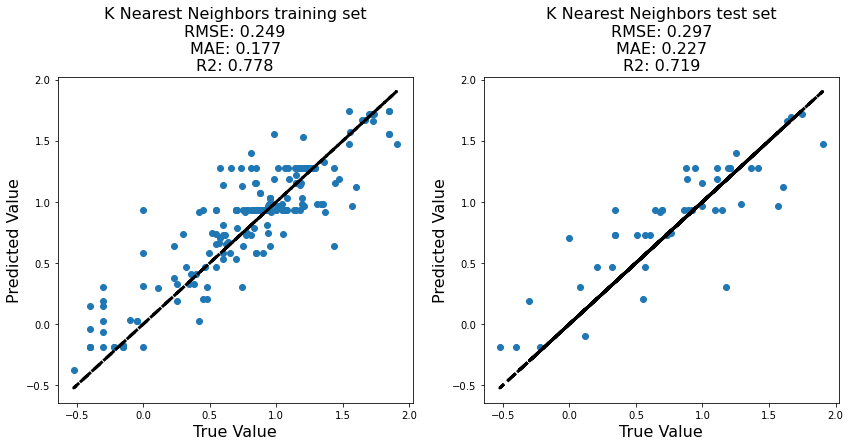

In [27]:
opt_par = knr_gp.x

# use hyper-parameters from optimization 
n_neighbors = opt_par[0]
algorithm = opt_par[1] 
p = opt_par[2]

#K-Nearest Regression
knregressor = KNeighborsRegressor(n_neighbors=n_neighbors,algorithm=algorithm,p=p)

knregressor.fit(X_train,y_train)
y_pred_train = knregressor.predict(X_train)
y_pred_test = knregressor.predict(X_test)

rmse, mae, R2 = plot('K Nearest Neighbors', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['K Nearest Neighbors'] = rmse
mae_scores['K Nearest Neighbors'] = mae
R2_scores['K Nearest Neighbors'] = R2

In [35]:
# Hyperparameter optimization of Support Vector Regressor
svregressor = SVR()

svr_space  = [Categorical(categories=['linear', 'rbf', 'sigmoid'], name='kernel'),
              Real(0.0001, 10, "log-uniform", name='gamma'),
              Real(0.01, 100, name='C')]

@use_named_args(svr_space)
def objective(**params):
    svregressor.set_params(**params)
    return -np.mean(cross_val_score(svregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

svr_gp = gp_minimize(objective, svr_space, n_calls=100, n_jobs=-1, random_state=0)

C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

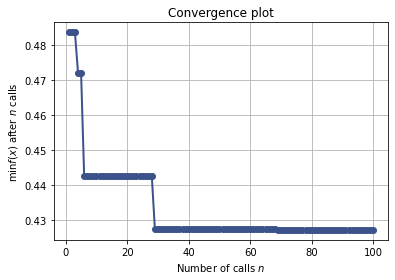

In [36]:
plot_convergence(svr_gp)

array([[<AxesSubplot:xlabel='kernel', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='gamma'>,
        <AxesSubplot:xlabel='gamma', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='kernel', ylabel='C'>,
        <AxesSubplot:xlabel='gamma'>,
        <AxesSubplot:xlabel='C', ylabel='Partial dependence'>]],
      dtype=object)

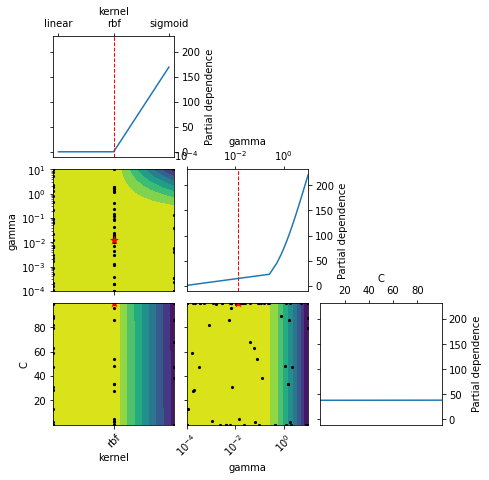

In [37]:
plot_objective(svr_gp)

In [38]:
# Hyperparameter for Support Vector Regressor
svr_gp.x

['rbf', 0.012956778121148111, 100.0]

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


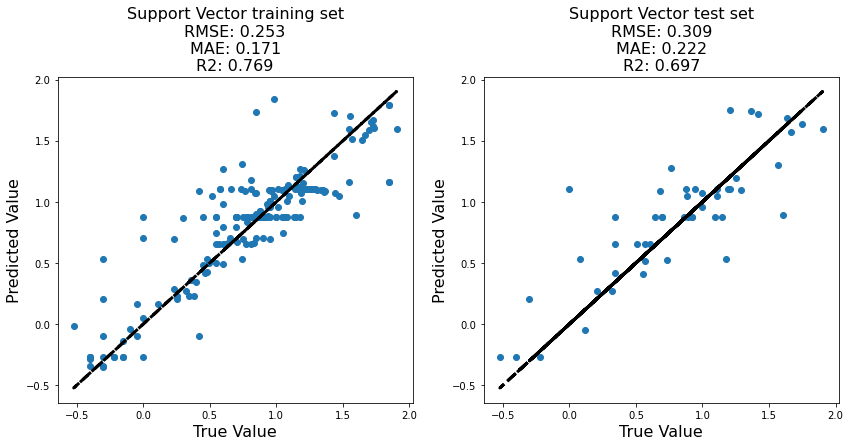

In [28]:
opt_par = svr_gp.x

# use hyper-parameters from optimization 
kernel = opt_par[0]
gamma = opt_par[1]
C = opt_par[2]

# Decision Tree Regression
svregressor = SVR(kernel=kernel, gamma=gamma, C=C)

svregressor.fit(X_train,y_train)
y_pred_train = svregressor.predict(X_train).reshape(-1, 1)
y_pred_test = svregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Support Vector', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Support Vector'] = rmse
mae_scores['Support Vector'] = mae
R2_scores['Support Vector'] = R2

In [40]:
# Hyperparameter optimization of Decision Tree Regressor
dtregressor = DecisionTreeRegressor(random_state=0)

dtr_space  = [Categorical(categories=['squared_error', 'absolute_error', 'friedman_mse'], name='criterion'),
              Categorical(categories=['best', 'random'], name='splitter'),
              Integer(1, 100, name='max_depth')]

@use_named_args(dtr_space)
def objective(**params):
    dtregressor.set_params(**params)
    return -np.mean(cross_val_score(dtregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

dtr_gp = gp_minimize(objective, dtr_space, n_calls=100, n_jobs=-1, random_state=0)

C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

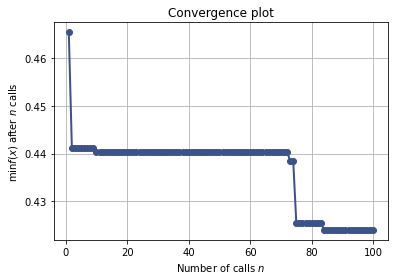

In [41]:
plot_convergence(dtr_gp)

array([[<AxesSubplot:xlabel='criterion', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='splitter'>,
        <AxesSubplot:xlabel='splitter', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='criterion', ylabel='max_depth'>,
        <AxesSubplot:xlabel='splitter'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

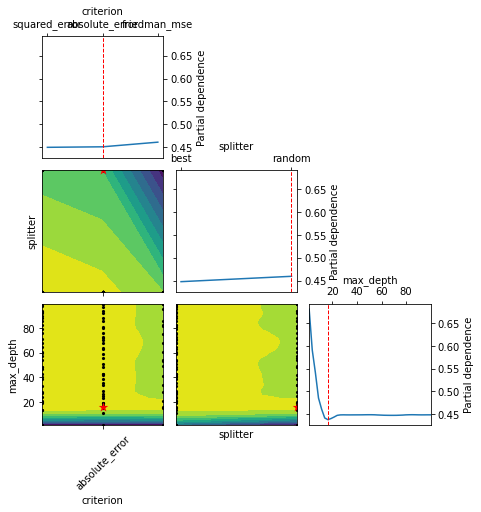

In [42]:
plot_objective(dtr_gp)

In [43]:
# Hyperparameter for Decision Tree Regressor
dtr_gp.x

['absolute_error', 'random', 16]

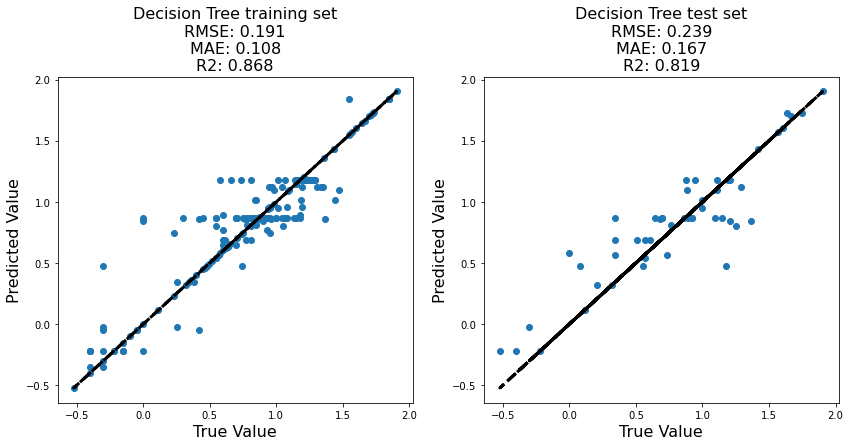

In [29]:
opt_par = dtr_gp.x

# use hyper-parameters from optimization 
criterion = opt_par[0]
splitter = opt_par[1]
max_depth = opt_par[2]

# Decision Tree Regression
dtregressor = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth, random_state=0)

dtregressor.fit(X_train,y_train)
y_pred_train = dtregressor.predict(X_train).reshape(-1, 1)
y_pred_test = dtregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Decision Tree', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Decision Tree'] = rmse
mae_scores['Decision Tree'] = mae
R2_scores['Decision Tree'] = R2

In [45]:
# Hyperparameter optimization of Gradient Boosting Regressor
gbregressor = GradientBoostingRegressor(random_state=0)

gbr_space  = [Real(0.005, 0.9, "log-uniform", name='learning_rate'),
              Categorical(categories=['squared_error', 'absolute_error', 'huber', 'quantile'], name='loss'),
              Integer(1, 1000, name='n_estimators'),
              Integer(1, 50, name='max_depth'),
              Real(0.005, 0.9, "log-uniform", name='alpha')]

@use_named_args(gbr_space)
def objective(**params):
    gbregressor.set_params(**params)
    return -np.mean(cross_val_score(gbregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

gbr_gp = gp_minimize(objective, gbr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

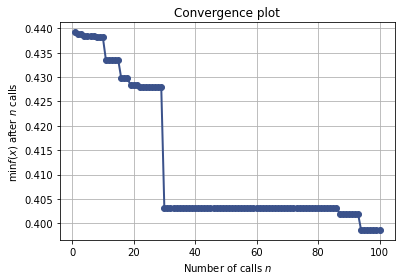

In [46]:
plot_convergence(gbr_gp)

array([[<AxesSubplot:xlabel='learning_rate', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='loss'>,
        <AxesSubplot:xlabel='loss', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n_estimators'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='learning_rate', ylabel='alpha'>,
        <AxesSubplot:xlabel='loss'>, <AxesSubplot:xlabel='n_estimators'>,
        <AxesSubplot:xlabel='max_depth'>,
        <AxesSubplot:xlabel='alpha', ylabel='Partial dependence'>]],
      dtype=object)

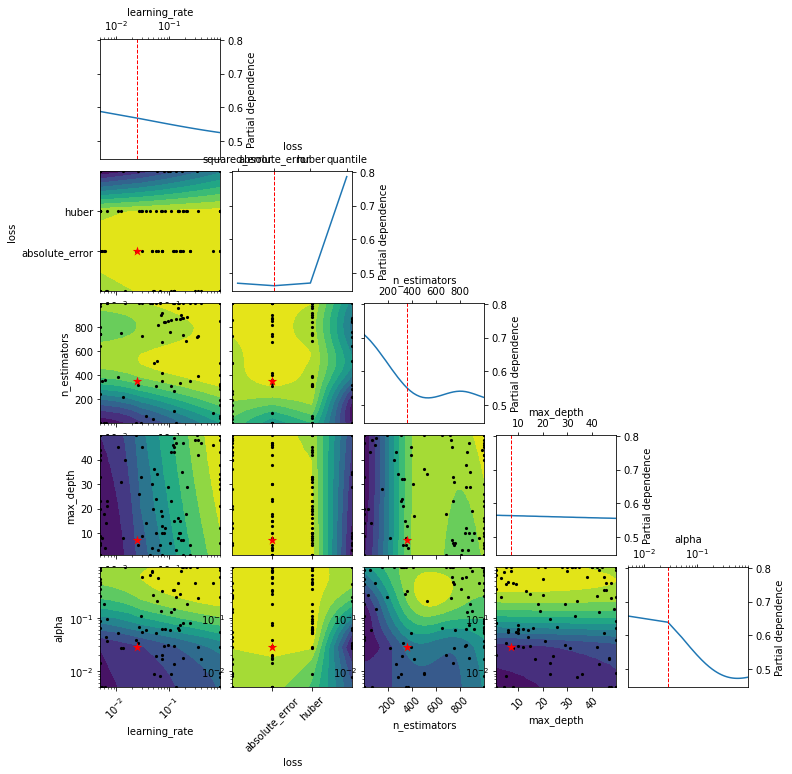

In [47]:
plot_objective(gbr_gp)

In [48]:
# Hyperparameter for Gradient Boosting Regressor
gbr_gp.x

[0.02413913529538548, 'absolute_error', 354, 7, 0.02815861319102748]

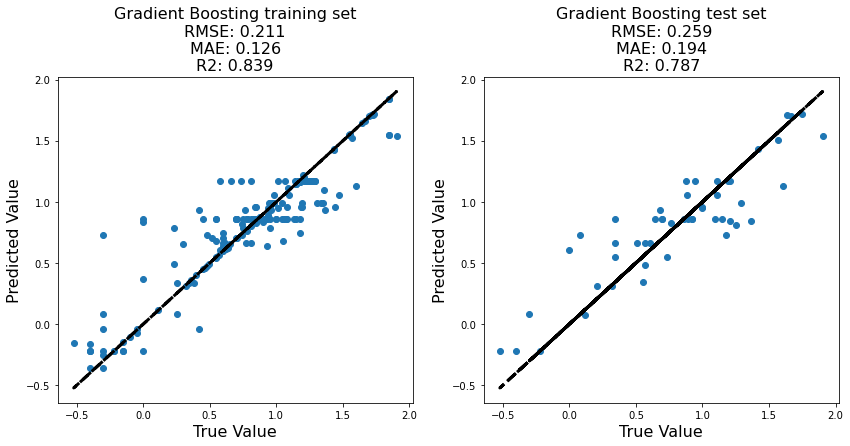

In [30]:
opt_par = gbr_gp.x

# use hyper-parameters from optimization 
learning_rate = opt_par[0]
loss = opt_par[1] 
n_estimators = opt_par[2]
max_depth = opt_par[3]
alpha = opt_par[4]

# Gradient Boosting Regression
gbregressor = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate,
                                        max_depth = max_depth, loss = loss, alpha= alpha, random_state=0)

gbregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = gbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = gbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Gradient Boosting', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Gradient Boosting'] = rmse
mae_scores['Gradient Boosting'] = mae
R2_scores['Gradient Boosting'] = R2

In [50]:
# Hyperparameter optimization of Random Forest Regressor
rfregressor = RandomForestRegressor(random_state=0)

rfr_space  = [Integer(1, 2000, name='n_estimators'),
              Integer(1, 50, name='max_depth')]

@use_named_args(rfr_space)
def objective(**params):
    rfregressor.set_params(**params)
    return -np.mean(cross_val_score(rfregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

rfr_gp = gp_minimize(objective, rfr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

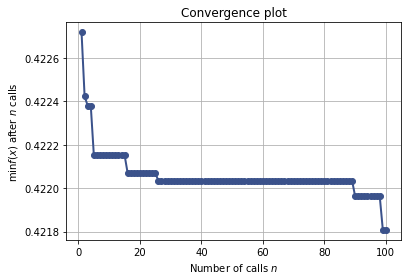

In [51]:
plot_convergence(rfr_gp)

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='max_depth'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

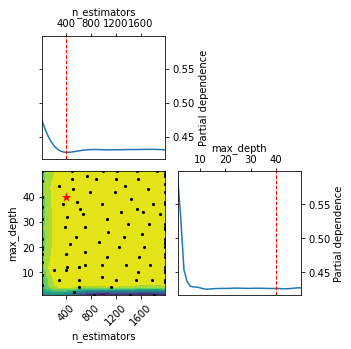

In [52]:
plot_objective(rfr_gp)

In [53]:
# Hyperparameter for Random Forest Regressor
rfr_gp.x

[390, 40]

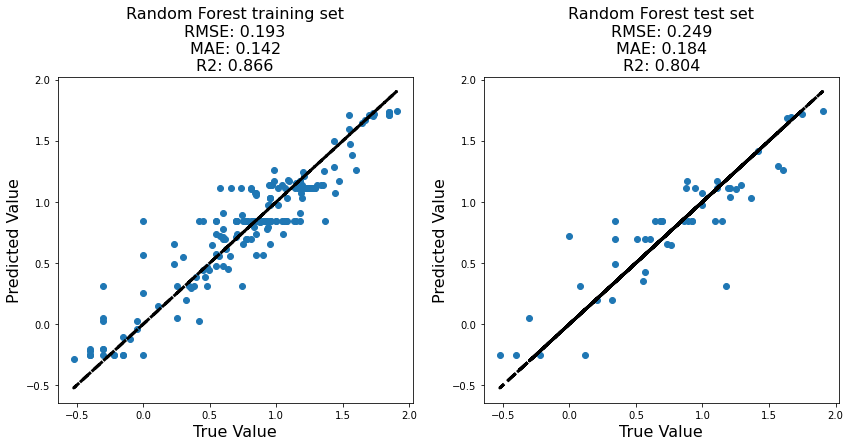

In [31]:
opt_par = rfr_gp.x

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Random Forest Regression
rfregressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

rfregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = rfregressor.predict(X_train).reshape(-1, 1)
y_pred_test = rfregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Random Forest', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Random Forest'] = rmse
mae_scores['Random Forest'] = mae
R2_scores['Random Forest'] = R2

In [55]:
# Hyperparameter optimization of Extra Trees Regressor
etregressor = ExtraTreesRegressor(random_state=0)

etr_space  = [Integer(1, 2000, name='n_estimators'),
              Integer(1, 50, name='max_depth')]

@use_named_args(etr_space)
def objective(**params):
    etregressor.set_params(**params)
    return -np.mean(cross_val_score(etregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

etr_gp = gp_minimize(objective, etr_space, n_calls=100, n_jobs=-1, random_state=0)

C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

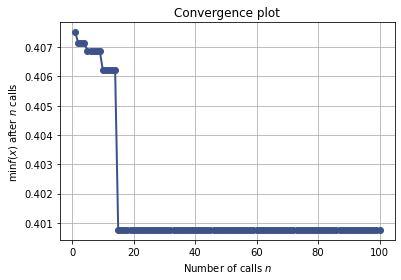

In [56]:
plot_convergence(etr_gp)

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='max_depth'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

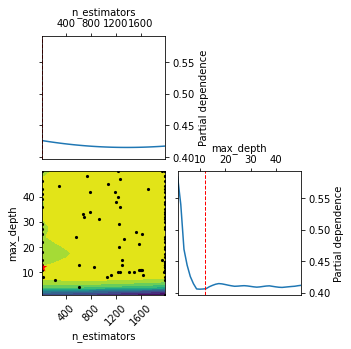

In [57]:
plot_objective(etr_gp)

In [58]:
# Hyperparameter for Extra Trees Regressor
etr_gp.x

[7, 12]

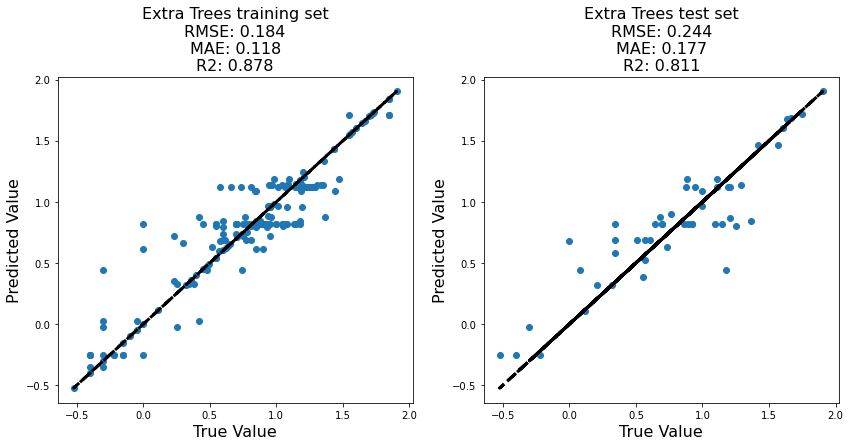

In [32]:
opt_par = etr_gp.x

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Extra Trees Regression
etregressor = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

etregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = etregressor.predict(X_train).reshape(-1, 1)
y_pred_test = etregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Extra Trees', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Extra Trees'] = rmse
mae_scores['Extra Trees'] = mae
R2_scores['Extra Trees'] = R2

In [60]:
# Hyperparameter optimization of XGBoost Regressor
xgbregressor = XGBRegressor(random_state=0)

xgbr_space  = [Real(0.005, 1, "log-uniform", name='eta'),
              Integer(1, 200, name='n_estimators'),
              Integer(1, 20, name='max_depth'),
              Real(0.1, 1, "log-uniform", name='subsample'),
              Real(0.005, 1, "log-uniform", name='colsample_bytree')]

@use_named_args(xgbr_space)
def objective(**params):
    xgbregressor.set_params(**params)
    return -np.mean(cross_val_score(xgbregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

xgbr_gp = gp_minimize(objective, xgbr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

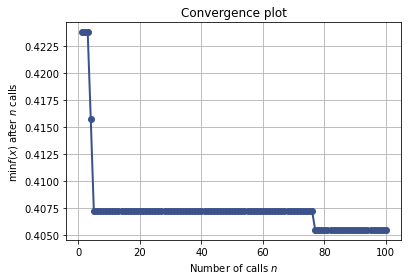

In [61]:
plot_convergence(xgbr_gp)

array([[<AxesSubplot:xlabel='eta', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n_estimators'>,
        <AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='subsample'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='subsample', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='eta', ylabel='colsample_bytree'>,
        <AxesSubplot:xlabel='n_estimators'>,
        <AxesSubplot:xlabel='max_depth'>,
        <AxesSubplot:xlabel='subsample'>,
        <AxesSubplot:xlabel='colsample_bytree', ylabel='Partial dependence'>]],
      dtype=object)

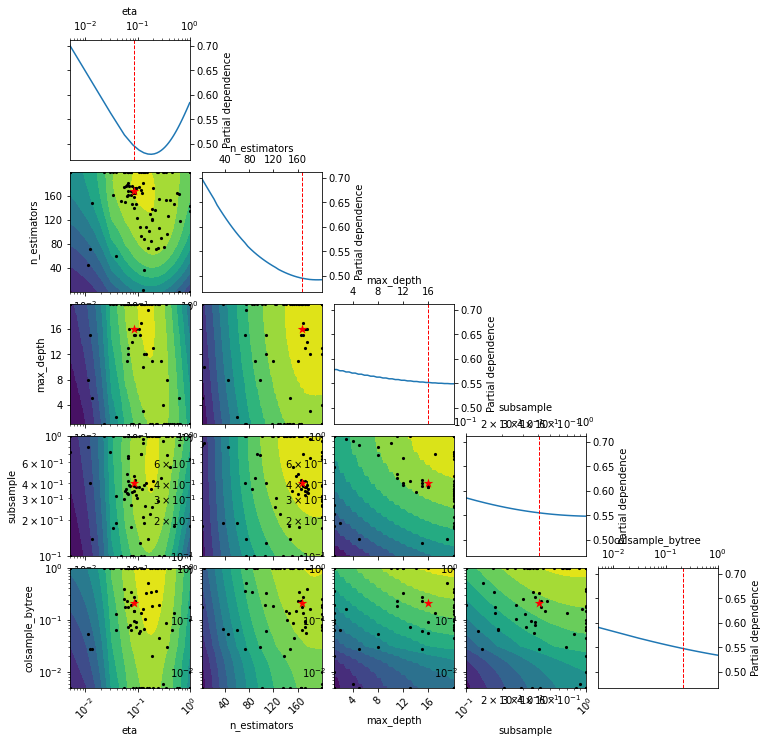

In [62]:
plot_objective(xgbr_gp)

In [63]:
# Hyperparameter for XGBoost Regressor
xgbr_gp.x

[0.08475441281803882, 168, 16, 0.40509016625609473, 0.21309076288456938]

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


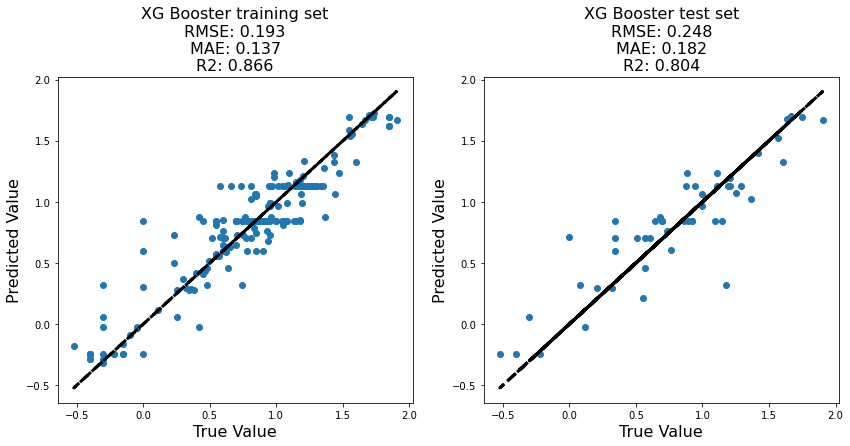

In [33]:
opt_par = xgbr_gp.x

# use hyper-parameters from optimization
eta= opt_par[0]
n_estimators = opt_par[1]
max_depth = opt_par[2]
subsample = opt_par[3]
colsample_bytree = opt_par[4]

#XGBoost Regression
xgbregressor = XGBRegressor(eta=eta, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample,
                            colsample_bytree=colsample_bytree, random_state=0)
    
xgbregressor.fit(X_train,y_train)
y_pred_train = xgbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = xgbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('XG Booster', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['XG Booster'] = rmse
mae_scores['XG Booster'] = mae
R2_scores['XG Booster'] = R2

In [34]:
# defining feature importance function
def feature_importance(regr, features, title):
    
    # getting the feature importance
    feature_importance = regr.feature_importances_
    # make importances relative to max importance
    feature_importance_n = 100.0 * (feature_importance / feature_importance.max())
    
    plt.barh(range(len(feature_importance)), feature_importance, tick_label=features)

    plt.xticks(fontsize=10)
    plt.xlabel('Relative Importance')

    plt.title(title, fontsize=16)
    plt.show()

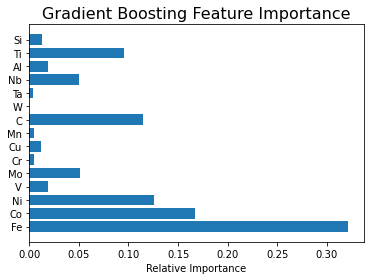

In [35]:
feature_importance(gbregressor, features, 'Gradient Boosting Feature Importance')

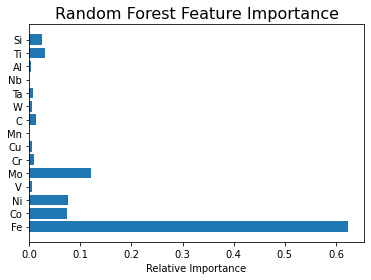

In [36]:
feature_importance(rfregressor, features, 'Random Forest Feature Importance')

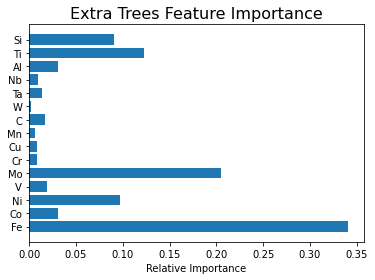

In [37]:
feature_importance(etregressor, features, 'Extra Trees Feature Importance')

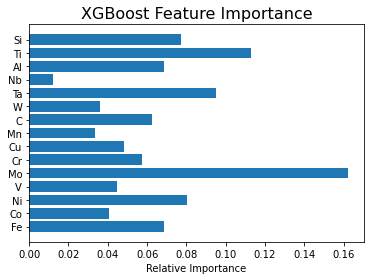

In [38]:
feature_importance(xgbregressor, features, 'XGBoost Feature Importance')

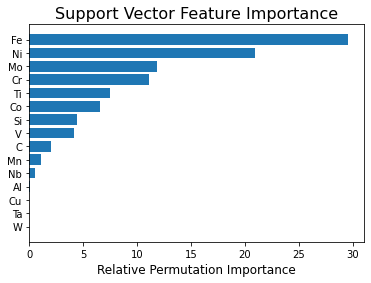

In [39]:
# Permutation importance for Support Vector regressor
from sklearn.inspection import permutation_importance

perm_imp  =  permutation_importance(svregressor, X_test,  y_test)

sorted_idx = perm_imp.importances_mean.argsort()
perm_imp_n = 100.0 * (perm_imp.importances_mean[sorted_idx] / sum(perm_imp.importances_mean))
plt.barh(features[sorted_idx], perm_imp_n)
plt.xlabel("Relative Permutation Importance", fontsize = 12)
plt.title('Support Vector Feature Importance', fontsize=16)
plt.show()

In [40]:
# Importing libraries for Neural Network Regression
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras import Sequential
from keras.layers import InputLayer, Dense, BatchNormalization

In [41]:
# Defining Hypermodel object to optimize hyperparameters for Neural Network Regression architecture with same number of units in hidden layers
class MyHyperModel(kt.HyperModel):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def build(self, hp):
        num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=10, step=1)
        units = hp.Int('units', min_value=16, max_value=1024, step=1)
        activation = hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid'])
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', values=['Adam', 'SGD', 'RMSprop'])
        
        params = dict(num_dense_layers = num_dense_layers,
                      units=units,
                      activation = activation,
                      lr = lr,
                      optimizer=optimizer)
        
        model = Sequential()
        model.add(InputLayer(input_shape=(self.X.shape[1],))) #Input Layer with training feature data shape
        model.add(BatchNormalization())
        for i in range(params['num_dense_layers']):
            name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
            model.add(Dense(units=params['units'],activation=params['activation'], name=name)) #add hidden layer(s)
            model.add(BatchNormalization())
        model.add(Dense(1, activation='linear')) #final layer before output layer
        # 3 types of optimizers are used for finding the best suited with best learning rate
        if params['optimizer'] == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=params['lr'])
        if params['optimizer'] == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=params['lr'])
        if params['optimizer'] == 'RMSprop':
            opt = keras.optimizers.RMSprop(learning_rate=params['lr'])
        model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         batch_size = hp.Int('batch_size', min_value=8, max_value=200, step=1),
                         #epochs = hp.Int('epochs', min_value=10, max_value=100, step=1),
                         validation_split=0.2,
                         **kwargs,)

In [42]:
# Hyperband Optimization from Keras-Tuner is used for hyperparameter optimization and the complete search space is stored in the working folder
import os
tuner = kt.Hyperband(MyHyperModel(X_train,y_train),
                     objective=kt.Objective("val_loss",direction="min"), max_epochs=100, factor=3,
                     overwrite=False, #in case of reloading the trial runs results
                     directory=os.path.normpath('logElong_keras_tuner_Hyb'), project_name='first_run')

In [43]:
tuner.search(X_train, y_train)

Trial 254 Complete [00h 00m 11s]
val_loss: 0.39692360162734985

Best val_loss So Far: 0.33566349744796753
Total elapsed time: 00h 11m 49s
INFO:tensorflow:Oracle triggered exit


In [44]:
tuner.results_summary()

Results summary
Results in C:\Users\shakt\Desktop\ms2-ML\logElong_keras_tuner_Hyb\first_run
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_dense_layers: 6
units: 431
activation: elu
learning_rate: 8.390102759615902e-05
optimizer: Adam
batch_size: 9
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: c052a7fb7f5624751e54253f8e0c5ded
Score: 0.33566349744796753
Trial summary
Hyperparameters:
num_dense_layers: 2
units: 412
activation: elu
learning_rate: 0.0019120403273945171
optimizer: RMSprop
batch_size: 25
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: d87291d08eda01ab445008420e54064c
Score: 0.3487948179244995
Trial summary
Hyperparameters:
num_dense_layers: 1
units: 47
activation: tanh
learning_rate: 0.031923576008690176
optimizer: RMSprop
batch_size: 9
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0a531634f3f

In [45]:
# Printing the best hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

for h_param in ['num_dense_layers', 'units', 'activation', 'learning_rate', 'optimizer', 'batch_size', 'tuner/epochs']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

num_dense_layers 6
units 431
activation elu
learning_rate 8.390102759615902e-05
optimizer Adam
batch_size 9
tuner/epochs 100


In [46]:
# Storing the hyperparameters in variables to develop the NN architecture
num_dense_layers = best_hps.get('num_dense_layers')
units = best_hps.get('units')
activation = best_hps.get('activation')
learning_rate = best_hps.get('learning_rate')
optimizer = best_hps.get('optimizer')
batch_size = best_hps.get('batch_size')
epochs = best_hps.get('tuner/epochs')

In [47]:
# function to develop NN architecture with same number of units in all hidden layers
def build_and_compile_model(num_dense_layers,units,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
        model.add(Dense(units,activation=activation,name=name)) #add hidden layer(s)
        model.add(BatchNormalization())
    model.add(Dense(1, activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [58]:
# Create the neural network with these hyper-parameters.
model1 = build_and_compile_model(num_dense_layers, units, activation, learning_rate, optimizer)
    
# Train the model.
history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

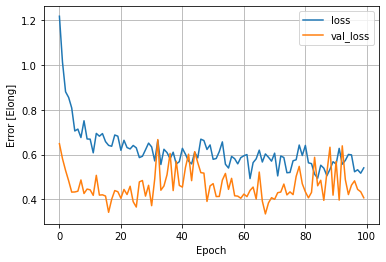

In [59]:
# function to plot the training and validation history of the NN
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Elong]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [60]:
print('Mean Absolute Error (logElong), Mean Squared Error (logElong): ', model1.evaluate(X_test, y_test, verbose=0))

Mean Absolute Error (logElong), Mean Squared Error (logElong):  [0.4700477719306946, 0.3822377920150757]


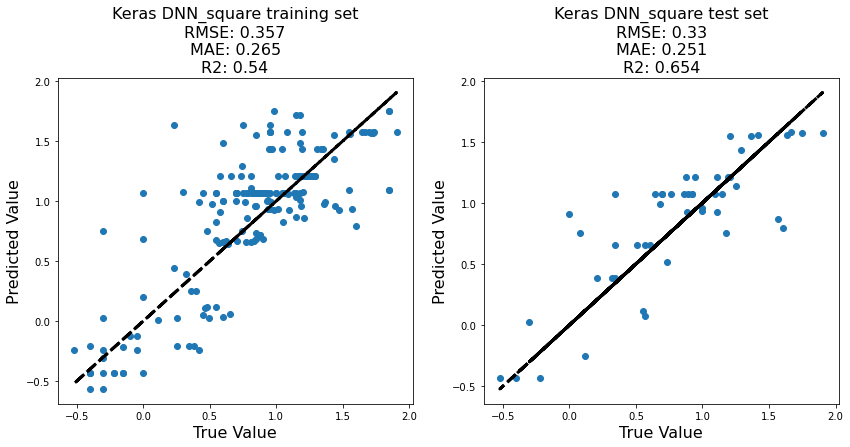

In [61]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model1.predict(X_train)
y_pred_test=model1.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_square', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_square'] = rmse
mae_scores['Keras DNN_square'] = mae
R2_scores['Keras DNN_square'] = R2

In [62]:
# Defining Hypermodel object to optimize hyperparameters for Neural Network Regression architecture with different number of units in different hidden layers
class MyHyperModel2(kt.HyperModel):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def build(self, hp):
        units_1 = hp.Int('units_1', min_value=16, max_value=1024, step=1)
        units_2 = hp.Int('units_2', min_value=16, max_value=1024, step=1)
        units_3 = hp.Int('units_3', min_value=16, max_value=1024, step=1)
        units_4 = hp.Int('units_4', min_value=16, max_value=1024, step=1)
        units_5 = hp.Int('units_5', min_value=16, max_value=1024, step=1)
        units_6 = hp.Int('units_6', min_value=16, max_value=1024, step=1)
        activation = hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid'])
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', values=['Adam', 'SGD', 'RMSprop'])
        
        params = dict(units_1=units_1,
                      units_2=units_2,
                      units_3=units_3,
                      units_4=units_4,
                      units_5=units_5,
                      units_6=units_6,
                      activation = activation,
                      lr = lr,
                      optimizer=optimizer)
        
        model = Sequential()
        model.add(InputLayer(input_shape=(self.X.shape[1],))) #Input Layer with training feature data shape
        model.add(BatchNormalization())
        # The number of hidden layers are same as previous NN architecture
        model.add(Dense(units=params['units_1'],activation=params['activation'], name='layers_dense_1')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_2'],activation=params['activation'], name='layers_dense_2')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_3'],activation=params['activation'], name='layers_dense_3')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_4'],activation=params['activation'], name='layers_dense_4')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_5'],activation=params['activation'], name='layers_dense_5')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_6'],activation=params['activation'], name='layers_dense_6')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(1, activation='linear')) #final layer before output layer
        # 3 types of optimizers are used for finding the best suited with best learning rate
        if params['optimizer'] == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=params['lr'])
        if params['optimizer'] == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=params['lr'])
        if params['optimizer'] == 'RMSprop':
            opt = keras.optimizers.RMSprop(learning_rate=params['lr'])
        model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         batch_size = hp.Int('batch_size', min_value=8, max_value=200, step=1),
                         #epochs = hp.Int('epochs', min_value=10, max_value=100, step=1),
                         validation_split=0.2,
                         **kwargs,)

In [63]:
# Hyperband Optimization from Keras-Tuner is used for hyperparameter optimization and the complete search space is stored in the working folder
import os
tuner2 = kt.Hyperband(MyHyperModel2(X_train,y_train),
                     objective=kt.Objective("val_loss",direction="min"), max_epochs=100, factor=3,
                     overwrite=False, #in case of reloading the trial runs results
                     directory=os.path.normpath('logElong_keras_tuner_Hyb'), project_name='first_run_random')

In [64]:
tuner2.search(X_train, y_train)

Trial 254 Complete [00h 00m 11s]
val_loss: 0.4065602421760559

Best val_loss So Far: 0.3246445655822754
Total elapsed time: 00h 12m 48s
INFO:tensorflow:Oracle triggered exit


In [65]:
tuner2.results_summary()

Results summary
Results in C:\Users\shakt\Desktop\ms2-ML\logElong_keras_tuner_Hyb\first_run_random
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_1: 579
units_2: 627
units_3: 291
units_4: 431
units_5: 410
units_6: 877
activation: tanh
learning_rate: 0.00026605572499101596
optimizer: Adam
batch_size: 32
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 011b432066d869442b92c9cc487b9a0f
Score: 0.3246445655822754
Trial summary
Hyperparameters:
units_1: 579
units_2: 627
units_3: 291
units_4: 431
units_5: 410
units_6: 877
activation: tanh
learning_rate: 0.00026605572499101596
optimizer: Adam
batch_size: 32
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: d95848379b49bd148ef600f49dfdc306
Score: 0.3504524230957031
Trial summary
Hyperparameters:
units_1: 571
units_2: 166
units_3: 475
units_4: 374
units_5: 439
units_6: 147
activation: sigmoid
learning_rate: 0.0

In [66]:
# Printing the best hyperparameters
best_hps_2=tuner2.get_best_hyperparameters()[0]

for h_param in ['units_1', 'units_2', 'units_3', 'units_4', 'units_5', 'units_6', 'activation', 'learning_rate', 'optimizer', 'batch_size', 'tuner/epochs']:
    print(h_param, tuner2.get_best_hyperparameters()[0].get(h_param))

units_1 579
units_2 627
units_3 291
units_4 431
units_5 410
units_6 877
activation tanh
learning_rate 0.00026605572499101596
optimizer Adam
batch_size 32
tuner/epochs 100


In [69]:
# Storing the hyperparameters in variables to develop the NN architecture
units_1 = best_hps_2.get('units_1')
units_2 = best_hps_2.get('units_2')
units_3 = best_hps_2.get('units_3')
units_4 = best_hps_2.get('units_4')
units_5 = best_hps_2.get('units_5')
units_6 = best_hps_2.get('units_6')
activation = best_hps_2.get('activation')
learning_rate = best_hps_2.get('learning_rate')
optimizer = best_hps_2.get('optimizer')
batch_size = best_hps_2.get('batch_size')
epochs = best_hps_2.get('tuner/epochs')

In [70]:
# function to develop NN architecture with different number of units in different hidden layers
def compile_model(units_1,units_2,units_3,units_4,units_5,units_6,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    name = 'layer_dense_1'#name of hidden layer
    model.add(Dense(units_1, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_2'#name of hidden layer
    model.add(Dense(units_2, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_3'#name of hidden layer
    model.add(Dense(units_3, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_4'#name of hidden layer
    model.add(Dense(units_4, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_5'#name of hidden layer
    model.add(Dense(units_5, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_6'#name of hidden layer
    model.add(Dense(units_6, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [71]:
# Create the neural network with these hyper-parameters.
model2 = compile_model(units_1, units_2, units_3, units_4, units_5, units_6, activation, learning_rate, optimizer)
    
# Train the model.
history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

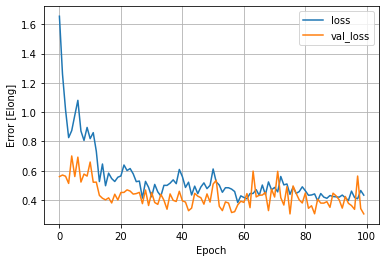

In [72]:
plot_loss(history)

In [73]:
print('Mean Absolute Error (logElong), Mean Squared Error (logElong): ', model2.evaluate(X_test, y_test, verbose=0))

Mean Absolute Error (logElong), Mean Squared Error (logElong):  [0.34873783588409424, 0.263519287109375]


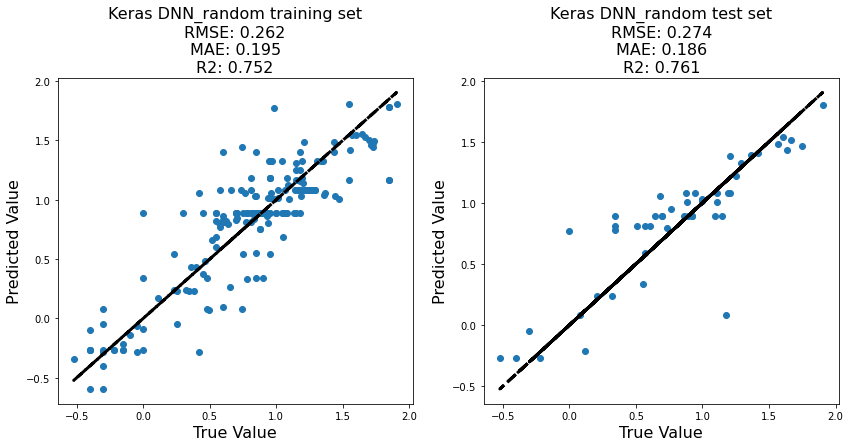

In [74]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model2.predict(X_train)
y_pred_test=model2.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_random', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_random'] = rmse
mae_scores['Keras DNN_random'] = mae
R2_scores['Keras DNN_random'] = R2

In [75]:
# Creating dataframe of the metrics of the 12 regressors used 
rmse = pd.DataFrame(list(rmse_scores.items()),columns = ['Regressor','RMSE'])
mae = pd.DataFrame(list(mae_scores.items()),columns = ['Regressor','MAE'])
r2 = pd.DataFrame(list(R2_scores.items()),columns = ['Regressor','R2'])
scores_df = pd.concat([rmse,mae.iloc[:,1],r2.iloc[:,1]],axis=1)
scores_df

,Regressor,RMSE,MAE,R2
0,Linear Regression,0.321,0.227,0.672
1,Ridge Regression,0.330,0.234,0.653
2,Lasso Regression,0.323,0.229,0.669
3,K Nearest Neighbors,0.297,0.227,0.719
4,Support Vector,0.309,0.222,0.697
5,Decision Tree,0.239,0.167,0.819
6,Gradient Boosting,0.259,0.194,0.787
7,Random Forest,0.249,0.184,0.804
8,Extra Trees,0.244,0.177,0.811
9,XG Booster,0.248,0.182,0.804


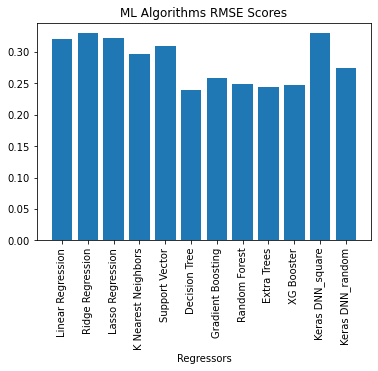

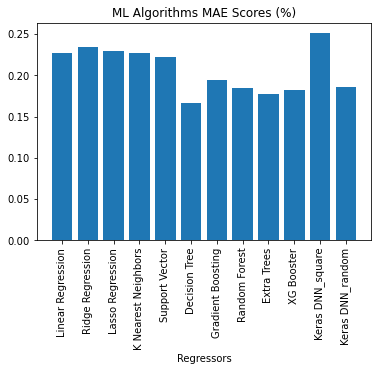

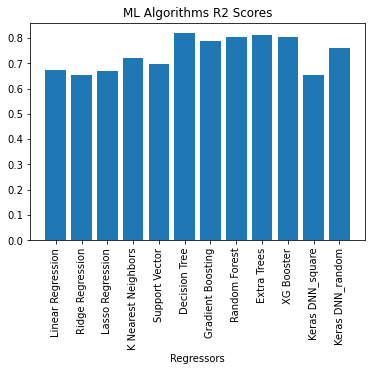

In [76]:
# Plotting the bar graph of the 3 metrics for all the models
plt.bar(range(len(rmse_scores.values())),list(rmse_scores.values()),  
        tick_label=list(rmse_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms RMSE Scores')
plt.show()

plt.bar(range(len(mae_scores.values())),list(mae_scores.values()),  
        tick_label=list(mae_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms MAE Scores (%)')
plt.show()

plt.bar(range(len(R2_scores.values())),list(R2_scores.values()),  
        tick_label=list(R2_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms R2 Scores')
plt.show()

In [77]:
# Exporting the performance metric results
scores_df.to_excel('Scores_logElong-comp.xlsx')

# Imputation

In [100]:
# Importing the database with imputed Ms, Hc, Tc & ER values
df1 = pd.read_csv('FeNiCo_comp-prop_imp.csv')
df1 = df1.iloc[:,1:]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Ms      1208 non-null   float64
 16  Hc      1208 non-null   float64
 17  Tc      1208 non-null   float64
 18  ER      1208 non-null   float64
 19  TS      244 non-null    float64
 20  YS      239 non-null    float64
 21  Elong   248 non-null    float64
 22  

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Elong   246 non-null    float64
dtypes: float64(16)
memory usage: 151.1 KB


In [103]:
# Predicting Elongation for all the compositions using the best model
X_imp = df.iloc[:,:-1]
X_transform = scalerX.transform(X_imp)
y_imp_transform = dtregressor.predict(X_transform).reshape(-1,1)
Elong_imp = pd.DataFrame(10**(scalerY.inverse_transform(y_imp_transform)),columns=["Elong"])
Elong_imp =Elong_imp.round(decimals=2)
Elong_imp

C:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


,Elong
0,40.00
1,40.00
2,40.00
3,40.00
4,40.00
...,...
1203,7.35
1204,7.35
1205,7.35
1206,7.35


In [104]:
# Filling up the empty cell with predicted Elongation values
df.Elong = df.Elong.fillna(Elong_imp.Elong)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Elong   1208 non-null   float64
dtypes: float64(16)
memory usage: 151.1 KB


In [105]:
# Creating a database with imputed Ms, Hc, Tc, ER & Elongation values
new_db = pd.concat([df1.iloc[:,:21],df.iloc[:,-1],df1.iloc[:,22:]], axis=1)
new_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Ms      1208 non-null   float64
 16  Hc      1208 non-null   float64
 17  Tc      1208 non-null   float64
 18  ER      1208 non-null   float64
 19  TS      244 non-null    float64
 20  YS      239 non-null    float64
 21  Elong   1208 non-null   float64
 22  

In [106]:
# Exporting the imputed database
new_db.to_csv('FeNiCo_comp-prop_imp.csv')